In [1]:
import numpy as np
import os


from lmfit.models import GaussianModel,Model
from sklearn.linear_model import LinearRegression
from sklearn import mixture,metrics

# нужно предварительно установить geos
# pip install geos
from shapely.geometry import Polygon  

from scipy.stats.distributions import norm
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde

    
from matplotlib import pyplot as plt
from matplotlib import cm

from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse

from scipy import ndimage as ndi
from scipy.spatial import distance
from numpy import linalg 

from skimage import io
from skimage.draw import ellipse
from skimage.color import rgb2gray
from skimage import filters
from skimage.morphology import disk

from PIL import Image, ImageDraw, ImageFilter,ImageOps
import copy
import cv2

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.ndimage import distance_transform_edt as edt
from skimage.draw import ellipse
from skimage.measure import find_contours, approximate_polygon,subdivide_polygon

from radio_beam.commonbeam import getMinVolEllipse


from utils import grainPreprocess,grainShow,grainMark,grainDraw,grainApprox,grainStats,grainMorphology


## Загружаем изображения

In [2]:
def img_load_preprocess(path,names,h=150,k=1):
    imgs_path=[path+'/'+name for name in names]
    imgs=[]
    for img_path in imgs_path:
        img=io.imread(img_path)
        img=grainPreprocess.image_preprocess(img,h,k)
        imgs.append(img)
    return imgs

In [3]:
path='images'
grain_names=['Ultra_Co8.jpg','Ultra_Co11.jpg','Ultra_Co6_2.jpg','Ultra_Co15.jpg','Ultra_Co25.jpg']
grain_images=img_load_preprocess(path,grain_names)

D:\PROJECTS\python\grain_segmentation\utils.py:61: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img=rgb2gray(gray)


## Распределение углов

In [4]:
def angles_legend(name,itype,mus,sigmas,amps,norm,):
    #
    # создание легенды распределения углов
    #
    
    mu1=round(mus[0],2)
    sigma1=round(sigmas[0],2)
    amp1=round(amps[0],2)

    mu2=round(mus[1],2)
    sigma2=round(sigmas[1],2)
    amp2=round(amps[1],2)
    
    val=round(norm,4)
    
    border='--------------\n'
    total_number='\n количество углов '+str(val)
    text_angle='\n шаг угла '+str(step)+' градусов'

    moda1='\n mu1 = '+str(mu1)+' sigma1 = '+str(sigma1)+' amp1 = '+str(amp1)
    moda2='\n mu2 = '+str(mu2)+' sigma2 = '+str(sigma2)+' amp2 = '+str(amp2)

    legend=border+name+' '+itype+total_number+text_angle+moda1+moda2
        
        
    return legend
    

In [5]:
def bimodal_gauss_approx(x,y):
    #
    # аппроксимация распределения бимодальным гауссом
    # и создание графика по параметрам распределения
    #
    
    mus,sigmas,amps=grainApprox.gaussian_fit_bimodal(y,x)

    x_gauss=np.arange(0,361)
    y_gauss=grainStats.gaussian_bimodal(x_gauss,mus[0],mus[1],sigmas[0],sigmas[1],amps[0],amps[1])
    
    return (x_gauss,y_gauss),mus,sigmas,amps
    

In [ ]:
def angles_approx(images,names,types,step,N,M,font_size=20):
    #
    # вывод распределения углов для разных образцов
    #
    texts=[]
    xy_scatter=[]
    y_pred=[]
    
    for j,image in enumerate(images):
        
        original_angles=grainMark.get_angles(image)
        angles,angles_set,dens_curve=grainStats.stats_preprocess(original_angles,step)
        
        
        x = angles_set
        y = dens_curve

        norm=np.sum(y)
        y=y/norm
        
        (x_gauss,y_gauss),mus,sigmas,amps=bimodal_gauss_approx(x,y)
       
        text=angles_legend(names[j],types[j],mus,sigmas,amps,norm)

        
        y_pred.append(y_gauss)
        xy_scatter.append((x,y))
        
        texts.append(text)
        
       
    plt.rcParams['font.size'] = '15'
    gs = gridspec.GridSpec(1, 1)
    plt.figure(figsize=(N,M))

    ax1 = plt.subplot(gs[0]) 

    markers=['v','s','D','d','p','*']
    for i in range(len(images)):
        marker=markers[i]
        ax1.plot(y_pred[i])
        ax1.scatter(xy_scatter[i][0],xy_scatter[i][1],marker=marker)


    ax1.legend(texts,fontsize=14,loc=1)
    plt.ylabel('p(x)', fontsize=font_size)
    plt.xlabel('угол связующего вещества, градусы', fontsize=font_size)


  #  print(texts)


  #  plt.savefig('распределение углов')
    plt.show()

In [ ]:
N=20
M=20
step=5

images=grain_images[:4]
names=grain_names[:4]
types=['мелкие зерна',' средние зерна',' крупные зерна','some grain','some grain']

angles_approx(images,names,types,step,N,M)

### Распределение угов для всех снимков одного класса

In [6]:
def angles_approx_all(images,names,types,step,N,M,font_size=20):
    #
    # вывод распределения углов для всех фотографий одного образца
    #
    texts=[]
    xy_scatter=[]
    y_pred=[]
    
    for i,images_list in enumerate(images):
        all_original_angles=[]
        
        for j,image in enumerate(images_list):
            original_angles=grainMark.get_angles(image)

            for angle in original_angles:
                all_original_angles.append(angle)

        angles,angles_set,dens_curve=grainStats.stats_preprocess(all_original_angles,step)


        x = angles_set
        y = dens_curve

        norm=np.sum(y)
        y=y/norm

        (x_gauss,y_gauss),mus,sigmas,amps=bimodal_gauss_approx(x,y)

        text=angles_legend(names[i],types[i],mus,sigmas,amps,norm)


        y_pred.append(y_gauss)
        xy_scatter.append((x,y))

        texts.append(text)
        
       
    plt.rcParams['font.size'] = '15'
    gs = gridspec.GridSpec(1, 1)
    plt.figure(figsize=(N,M))

    ax1 = plt.subplot(gs[0]) 

    markers=['v','s','D','d','p','*']
    for i in range(len(names)):
        marker=markers[i]
        ax1.plot(y_pred[i])
        ax1.scatter(xy_scatter[i][0],xy_scatter[i][1],marker=marker)


    ax1.legend(texts,fontsize=14,loc=1)
    plt.ylabel('p(x)', fontsize=font_size)
    plt.xlabel('угол связующего вещества, градусы', fontsize=font_size)


  #  print(texts)


  #  plt.savefig('распределение углов')
    plt.show()

In [7]:
images_dir='data'

folders_names=os.listdir(images_dir)
images_paths_raw=[os.listdir(images_dir+'/'+folder) for folder in folders_names]

images_paths=[]
for i,folder in enumerate(images_paths_raw):
    images_paths.append([])
    for image_path in folder:
         images_paths[i].append(images_dir+'/'+folders_names[i]+'/'+image_path)

In [8]:
folders_names

['Ultra_Co11', 'Ultra_Co15', 'Ultra_Co25', 'Ultra_Co6_2', 'Ultra_Co8']

In [9]:
%time
all_images=[]

for images_folder in images_paths:
    images=[grainPreprocess.image_preprocess(io.imread(name)) for i,name in enumerate(images_folder) if i<=100]
    all_images.append(images)

Wall time: 0 ns


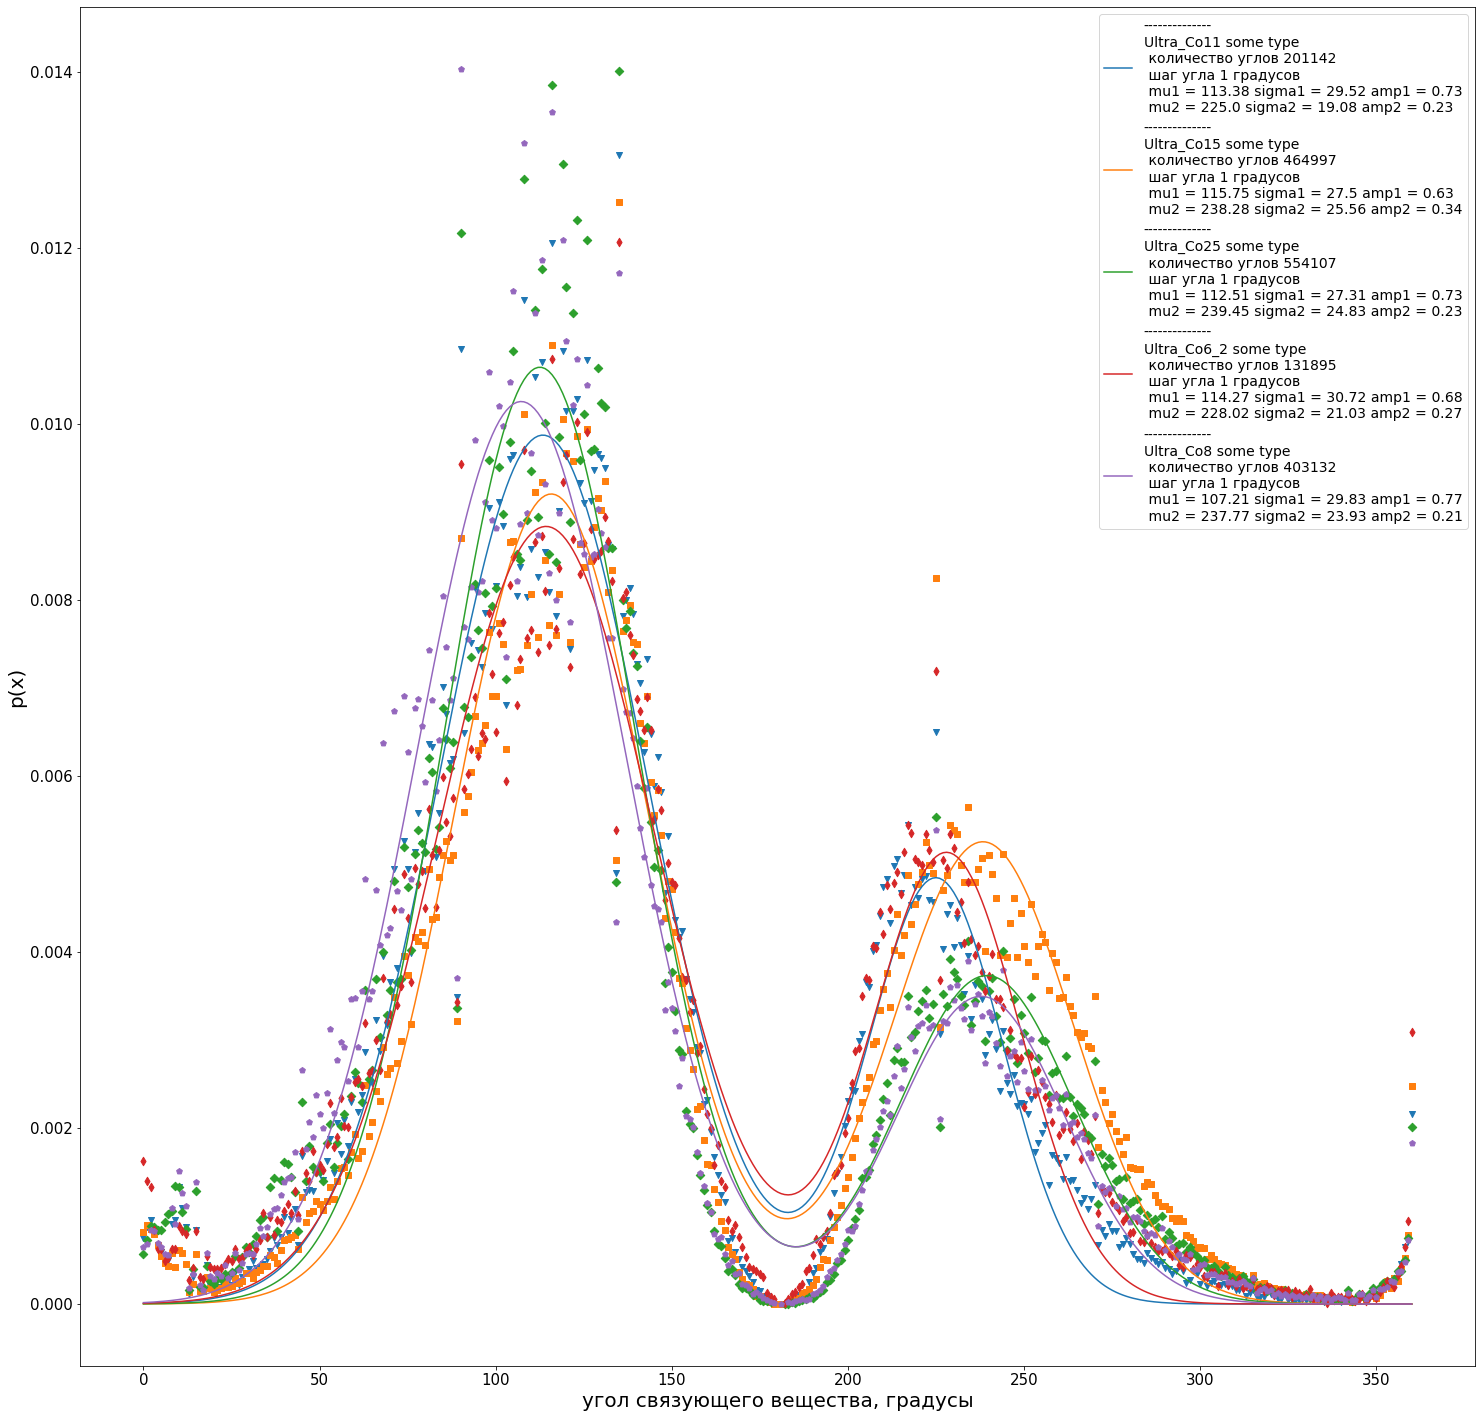

In [11]:
N=25
M=25
step=1

#images=grain_images[:4]
names=grain_names[:4]
#types=['мелкие зерна',' средние зерна',' крупные зерна','some grain','some grain']

images=all_images
names=folders_names
types=['some type','some type','some type','some type','some type','some type','some type']

angles_approx_all(images,names,types,step,N,M)

## Распределение диаметров

https://radio-beam.readthedocs.io/en/latest/api/radio_beam.commonbeam.getMinVolEllipse.html#radio_beam.commonbeam.getMinVolEllipse

In [25]:
def lin_regr_approx(x,y):
    #
    # аппроксимация распределения линейной функцией
    # и создание графика по параметрам распределения
    #
    x_pred=np.linspace(x.min(axis=0),x.max(axis=0),50)

    reg = LinearRegression().fit(x,y)
    y_pred=reg.predict(x_pred)

    k=reg.coef_[0][0]
    b=reg.predict([[0]])[0][0]

    angle=np.rad2deg(np.arctan(k))
    score=reg.score(x, y)

    return (x_pred,y_pred),k,b,angle,score


In [24]:
def beams_legend(name,itype,norm,k,angle,b,score,dist_step,dist_mean):
    #
    # создание легенды для распределения длин полуосей
    #
    border='--------------\n'
    num='\n количество регионов связ. в-ва  '+str(norm)
    lin_k='\n коэффициент k '+str(round((k),3))
    lin_k_angle='\n угол наклона '+str(round(angle,4))+' градусов, сдвиг b '+str(round(b,4))
    acc='\n точность '+str(round(score,2))
    text_step='\n шаг длины диаметра '+str(dist_step)+'$ мкм$'
    mean_text='\nсреднее значение длины '+str(round(dist_mean,2))
    legend=border+name+' '+itype+lin_k+ lin_k_angle+acc+num+text_step+mean_text
    
    return legend

In [26]:
def diametr_approx(images,names,types,step,pixel,N,M):
    #
    # вывод распределения длин а- и б- полуосей для разных образцов
    #
    texts1=[]
    texts2=[]
    
    xy_scatter1=[]
    xy_scatter2=[]
    
    xy_pred1=[]
    xy_pred2=[]

    
    for j,image in enumerate(images):

        a_beams,b_beams,angles,cetroids=grainMark.get_mvee_params(image,0.2)
        
        distances1,dist1_set,dens1_curve=grainStats.stats_preprocess(a_beams,step)
        distances2,dist2_set,dens2_curve=grainStats.stats_preprocess(b_beams,step)
        angles,angles_set,angles_dens_curve=grainStats.stats_preprocess(np.rad2deg(angles).astype('int32'),step=5)

        norm1=round(np.sum(dens1_curve),6)
        norm2=round(np.sum(dens2_curve),6)
        
        
        x1 = np.array([dist1_set]).reshape(-1, 1)*pixel
        y1 = np.log([dens1_curve/norm1]).reshape(-1, 1)
        
        x2 = np.array([dist2_set]).reshape(-1, 1)*pixel
        y2 = np.log([dens2_curve/norm2]).reshape(-1, 1)
        
        x1=x1[2:-3]
        y1=y1[2:-3]
        
        x2=x2[2:-3]
        y2=y2[2:-3]
        
        
        (x_pred1,y_pred1),k1,b1,angle1,score1=lin_regr_approx(x1,y1)
        (x_pred2,y_pred2),k2,b2,angle2,score2=lin_regr_approx(x2,y2)
        
        
        dist_step=pixel*step
        
        legend1=beams_legend(names[j],types[j],norm1,k1,angle1,b1,score1,dist_step,distances1.mean()*pixel)
        legend2=beams_legend(names[j],types[j],norm2,k2,angle2,b2,score2,dist_step,distances2.mean()*pixel)
        
        texts1.append(legend1)
        texts2.append(legend2)
        
        xy_scatter1.append((x1,y1))
        xy_scatter2.append((x2,y2))
        
        xy_pred1.append((x_pred1,y_pred1))
        xy_pred2.append((x_pred2,y_pred2))
        
        
    plt.rcParams['font.size'] = '15'
    gs = gridspec.GridSpec(2, 1)
    # для статьи 12,18
    plt.figure(figsize=(N,M))

    ax1 = plt.subplot(gs[0]) 
    ax2 = plt.subplot(gs[1])
    
    
    ax1.set_title('распределение a-полуосей связующего вещества', fontsize=15)
    ax2.set_title('распределение b-полуосей связующего вещества', fontsize=15)
    
    ax1.set_ylabel('ln(p(x))', fontsize=15)
    ax1.set_xlabel('длина полуоси, мкм', fontsize=15)
    
    ax2.set_ylabel('ln(p(x))', fontsize=15)
    ax2.set_xlabel('длина полуоси, мкм', fontsize=15)
    
  #  ax3.grid()
    markers=['v','s','D','d','p','*']
    for i in range(len(images)):
        marker=markers[i]
        ax1.plot(xy_pred1[i][0],xy_pred1[i][1])
        ax1.scatter(xy_scatter1[i][0],xy_scatter1[i][1],marker=marker)
        
        ax2.plot(xy_pred2[i][0],xy_pred2[i][1])
        ax2.scatter(xy_scatter2[i][0],xy_scatter2[i][1],marker=marker)
            
    #  plt.savefig('распределение полуосей')
    #  print(texts1)
    #  print(texts2)
    
    ax1.legend(texts1,fontsize=14,loc=1)
    ax2.legend(texts1,fontsize=14,loc=1)
    
    plt.show()   

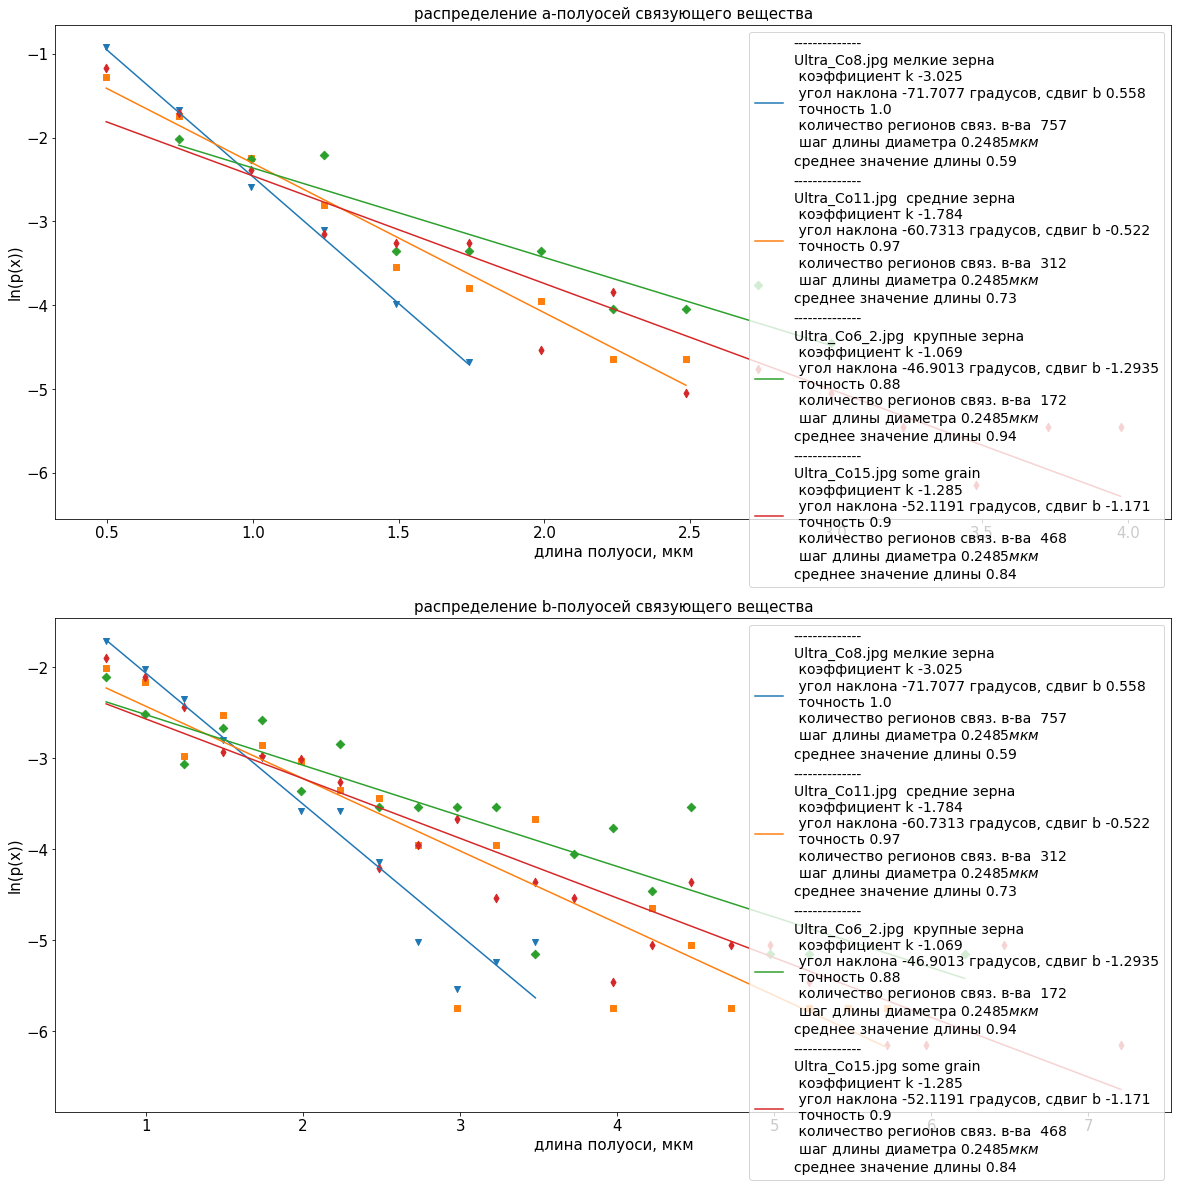

In [27]:
N=20
M=20
# для статье N=12,M=18
pixel=49.7/1000
step=5

images=grain_images[:4]
names=grain_names[:4]
types=['мелкие зерна',' средние зерна',' крупные зерна','some grain','some grain']

diametr_approx(images,names,types,step,pixel,N,M)

### Диаметры для всех образцов

In [57]:
def diametr_approx_all(images,names,types,step,pixel,N,M):
    #
    # вывод распределения длин а- и б- полуосей для разных образцов
    #
    texts1=[]
    texts2=[]
    
    xy_scatter1=[]
    xy_scatter2=[]
    
    xy_pred1=[]
    xy_pred2=[]

    for i,images_list in enumerate(images):
        all_a_beams=[]
        all_b_beams=[]
        
        for j,image in enumerate(images_list):
            try:
                a_beams,b_beams,angles,cetroids=grainMark.get_mvee_params(image,0.2)
                for k in range(len(a_beams)):
                    all_a_beams.append(a_beams[k])
                    all_b_beams.append(b_beams[k])
            except Exception:
                   pass
                    #print('error i=',i,' j=',j)
                
                
                
        distances1,dist1_set,dens1_curve=grainStats.stats_preprocess(all_a_beams,step)
        distances2,dist2_set,dens2_curve=grainStats.stats_preprocess(all_b_beams,step)
        
        angles,angles_set,angles_dens_curve=grainStats.stats_preprocess(np.rad2deg(angles).astype('int32'),step=5)

        norm1=round(np.sum(dens1_curve),6)
        norm2=round(np.sum(dens2_curve),6)
        
        
        x1 = np.array([dist1_set]).reshape(-1, 1)*pixel
        y1 = np.log([dens1_curve/norm1]).reshape(-1, 1)
        
        x2 = np.array([dist2_set]).reshape(-1, 1)*pixel
        y2 = np.log([dens2_curve/norm2]).reshape(-1, 1)
        
        x1=x1[2:-3]
        y1=y1[2:-3]
        
        x2=x2[2:-3]
        y2=y2[2:-3]
        
        
        (x_pred1,y_pred1),k1,b1,angle1,score1=lin_regr_approx(x1,y1)
        (x_pred2,y_pred2),k2,b2,angle2,score2=lin_regr_approx(x2,y2)
        
        
        dist_step=pixel*step
        
        legend1=beams_legend(names[i],types[i],norm1,k1,angle1,b1,score1,dist_step,distances1.mean()*pixel)
        legend2=beams_legend(names[i],types[i],norm2,k2,angle2,b2,score2,dist_step,distances2.mean()*pixel)
        
        texts1.append(legend1)
        texts2.append(legend2)
        
        xy_scatter1.append((x1,y1))
        xy_scatter2.append((x2,y2))
        
        xy_pred1.append((x_pred1,y_pred1))
        xy_pred2.append((x_pred2,y_pred2))
        
        
    plt.rcParams['font.size'] = '15'
    gs = gridspec.GridSpec(2, 1)
    # для статьи 12,18
    plt.figure(figsize=(N,M))

    ax1 = plt.subplot(gs[0]) 
    ax2 = plt.subplot(gs[1])
    
    
    ax1.set_title('распределение a-полуосей связующего вещества', fontsize=15)
    ax2.set_title('распределение b-полуосей связующего вещества', fontsize=15)
    
    ax1.set_ylabel('ln(p(x))', fontsize=15)
    ax1.set_xlabel('длина полуоси, мкм', fontsize=15)
    
    ax2.set_ylabel('ln(p(x))', fontsize=15)
    ax2.set_xlabel('длина полуоси, мкм', fontsize=15)
    
  #  ax3.grid()
    markers=['v','s','D','d','p','*']
    for i in range(len(images)):
        marker=markers[i]
        ax1.plot(xy_pred1[i][0],xy_pred1[i][1])
        ax1.scatter(xy_scatter1[i][0],xy_scatter1[i][1],marker=marker)
        
        ax2.plot(xy_pred2[i][0],xy_pred2[i][1])
        ax2.scatter(xy_scatter2[i][0],xy_scatter2[i][1],marker=marker)
            
    #  plt.savefig('распределение полуосей')
    #  print(texts1)
    #  print(texts2)
    
    ax1.legend(texts1,fontsize=14,loc=1)
    ax2.legend(texts2,fontsize=14,loc=1)
    
    plt.show()   

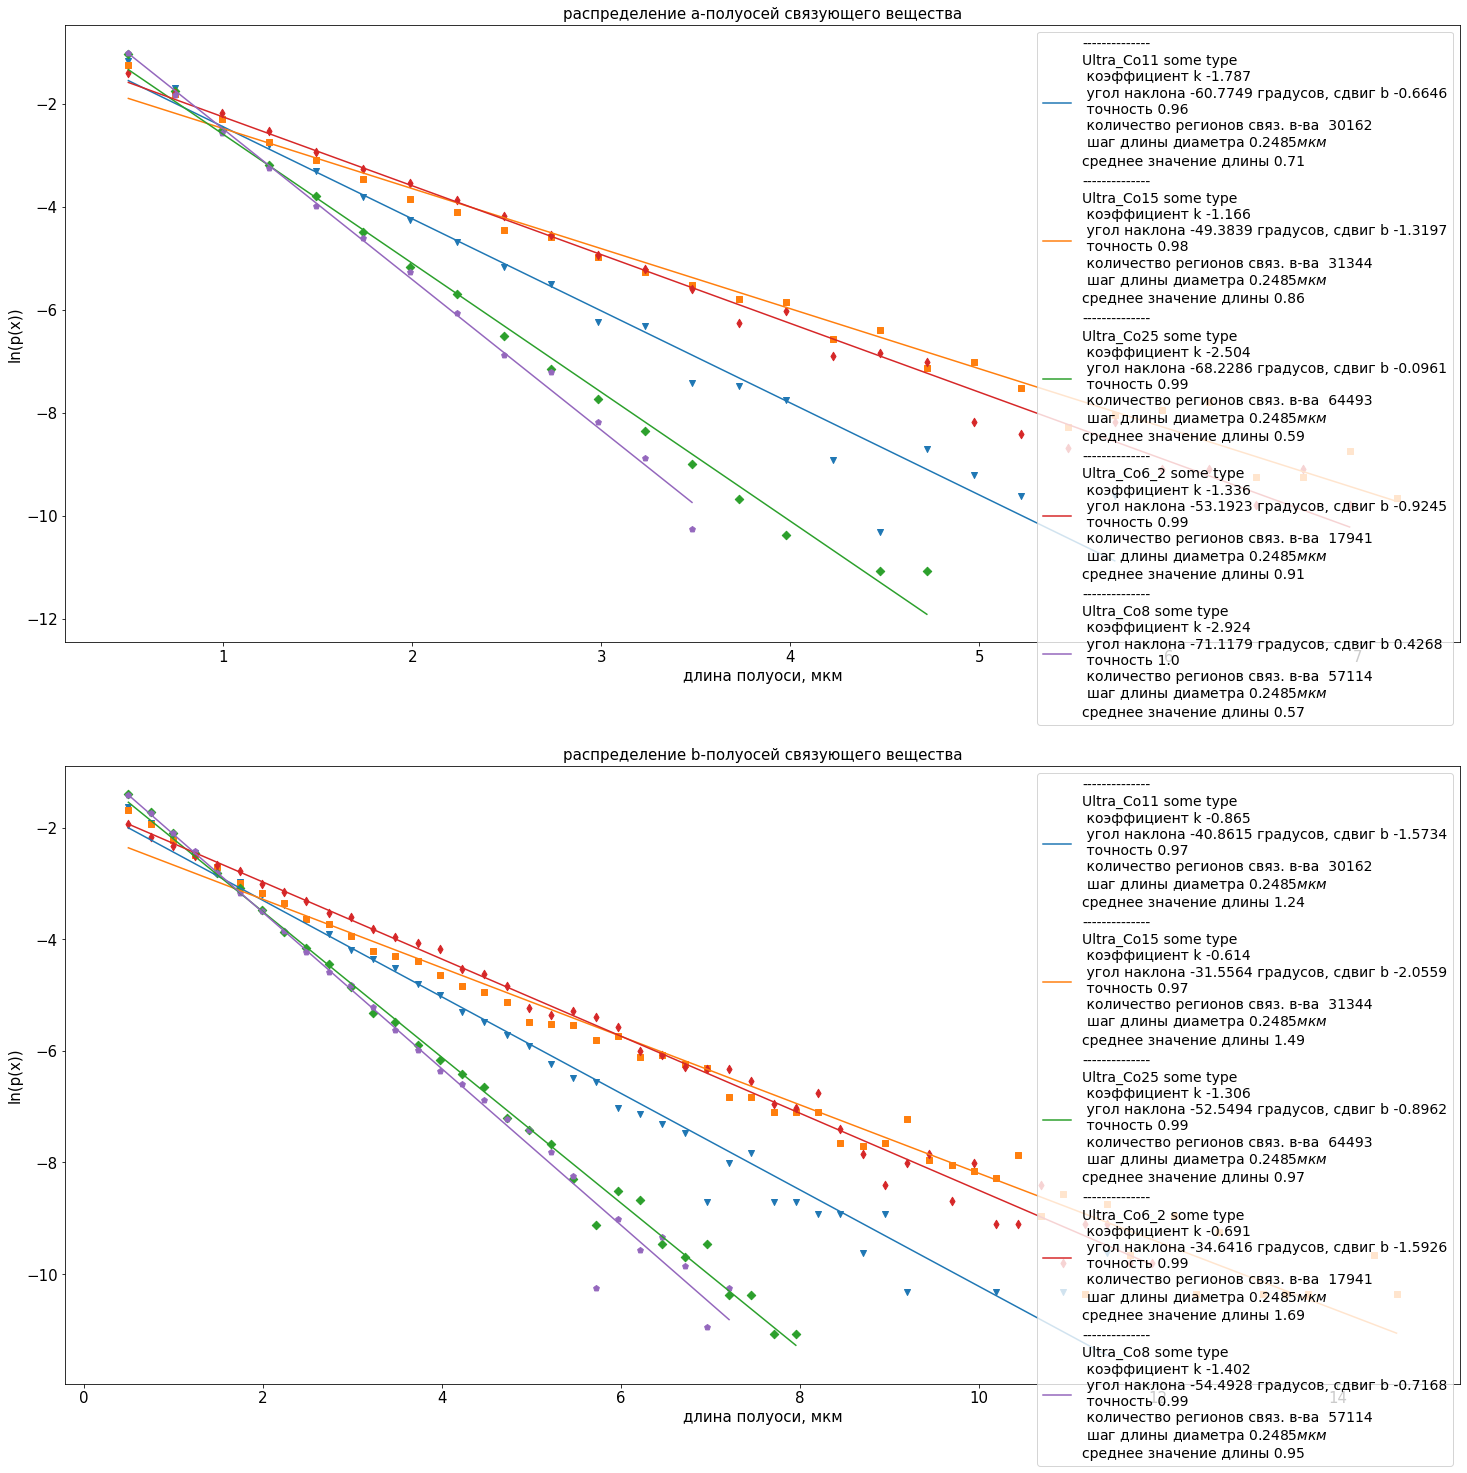

In [58]:
N=25
M=25
# для статье N=12,M=18
pixel=49.7/1000
step=5

images=all_images
names=folders_names
types=['some type','some type','some type','some type','some type','some type','some type']

diametr_approx_all(images,names,types,step,pixel,N,M)

In [54]:
#grainMark.get_mvee_params(images[0][15],0.2)

In [46]:
folders_names

['Ultra_Co11', 'Ultra_Co15', 'Ultra_Co25', 'Ultra_Co6_2', 'Ultra_Co8']